In [6]:
import numpy as np
import glob
import cv2
import blobfile as bf
import PIL
import copy
import matplotlib.pyplot as plt
from pytorch_lightning import seed_everything
seed_everything(47)

def _list_image_files_recursively(data_dir):
    results = []
    for entry in sorted(bf.listdir(data_dir)):
        full_path = bf.join(data_dir, entry)
        ext = entry.split(".")[-1]
        if "." in entry and ext.lower() in ["jpg", "jpeg", "png", "gif"]:
            results.append(full_path)
        elif bf.isdir(full_path):
            results.extend(_list_image_files_recursively(full_path))
    return results

Global seed set to 47


# How much background affect the lighting estimation from DECA?

In [7]:
# Load images of foreground/background/original

fgr_file = _list_image_files_recursively('./fgr/')
bgr_file = _list_image_files_recursively('./bgr/')
org_file = _list_image_files_recursively('./org/')
print(len(fgr_file), len(bgr_file), len(org_file))



file_dict = {}
for path in org_file:
    name = path.split('/')[-1]
    file_dict[name] = {'org':None, 'fgr':None}
    file_dict[name]['org'] = path
    file_dict[name]['fgr'] = [p for p in fgr_file if name.split('.')[0] in p][0]
    assert file_dict[name]['fgr'] != None
    assert file_dict[name]['org'] != None

# Check all images have paired.
tmp = copy.deepcopy(fgr_file)
for i in list(file_dict.keys()):
    i = i.split('.')[0]
    for idx, j in enumerate(tmp):
        if i in j:
            del(tmp[idx])
assert tmp == []


32 19 32


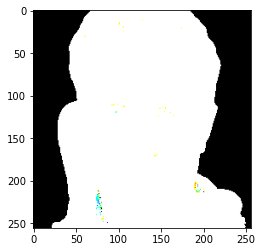

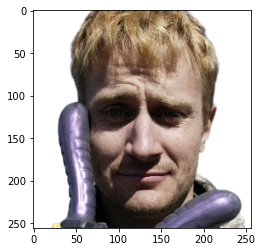

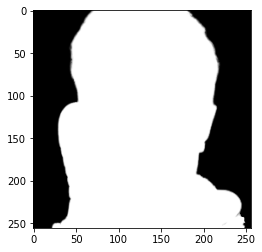

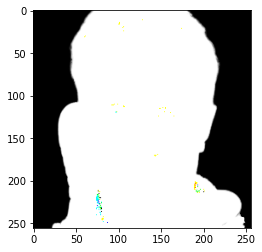

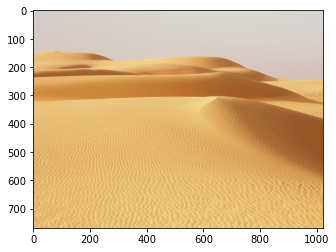

In [44]:
image_dict = copy.deepcopy(file_dict)
for name, v in file_dict.items():
    for k in ['org', 'fgr']:
        with bf.BlobFile(v[k], "rb") as f:
            pil_image = PIL.Image.open(f)
            pil_image.load()
            pil_image = pil_image.convert("RGBA")
        image_dict[name][k] = np.array(pil_image).astype(np.uint8)
    image_dict[name]['mask'] = image_dict[name]['fgr'] != 0
    # image_dict[name]['mask'] = 1 - np.isclose(image_dict[name]['fgr'], [0])
    # image_dict[name]['mask'] = image_dict[name]['mask'][..., [0]] * image_dict[name]['mask'][..., [1]] * image_dict[name]['mask'][..., [2]]

im = image_dict['60065.jpg']
# print(im['fgr'][..., 3])
# im = image_dict['60772.jpg']
# im = image_dict['60008.jpg']
# plt.imshow((np.concatenate((im['mask'], im['mask'], im['mask']), axis=-1) * 255).astype(np.uint8))
# plt.imshow(cv2.GaussianBlur(src=im['mask'].astype(np.uint8), ksize=(5, 5), sigmaX=30) * 255)
# plt.imshow((im['mask'] * 255).astype(np.uint8))
# holes = cv2.floodFill((im['mask']*255).astype(np.uint8), np.zeros((im['mask'].shape[0]+2, im['mask'].shape[1]+2)).astype(np.uint8), (0, 0), 255)[1]
# holes = ~holes
# im['mask'][holes == 255] = 255
plt.imshow((im['mask'][..., [0, 1, 2]] * 255).astype(np.uint8))
plt.show()
plt.imshow(im['fgr'])
plt.show()
gg = np.concatenate((im['fgr'][..., [3]], im['fgr'][..., [3]], im['fgr'][..., [3]]), axis=-1)
plt.imshow(gg)
plt.show()

plt.imshow(im['fgr'][..., [3]], cmap='gray')
plt.show()

plt.imshow(gg *(im['mask'][..., [0, 1, 2]]).astype(np.uint8) )
plt.show()

bgr_dict = {}
for path in bgr_file:
    name = path.split('/')[-1]
    with bf.BlobFile(path, "rb") as f:
        pil_image = PIL.Image.open(f)
        pil_image.load()
        pil_image = pil_image.convert("RGB")
    bgr_dict[name] = np.array(pil_image)

plt.imshow(bgr_dict['sahara.jpg'])
plt.show()

(256, 256, 1)
255
0


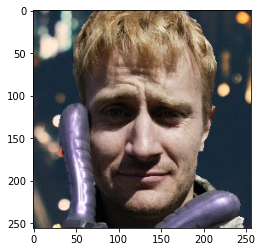

In [50]:
# Overlay the image
def overlay_image(fgr, bgr, mask):
    '''
    Overlay the image
    :param fgr: foreground image
    :param bgr: background image
    :param mask: mask image
    [#] All images need to be the same shape (H, W, 3)
    '''
    return (fgr * mask) + bgr * (1 - mask)

def random_crop(img, image_size=256):
    import random
    crop_y = random.randrange(img.shape[0] - image_size + 1)
    crop_x = random.randrange(img.shape[1] - image_size + 1)
    return img[crop_y : crop_y + image_size, crop_x : crop_x + image_size]

img_name = '60065.jpg'
bgr_name = [name for name in bgr_dict.keys() if 'night_city' in name][0]

ovl_im = overlay_image(fgr=image_dict[img_name]['fgr'][..., [0, 1, 2]], 
                    bgr=random_crop(bgr_dict[bgr_name]),
                    mask=image_dict[img_name]['fgr'][..., [3]] == 255)

print(image_dict[img_name]['fgr'][..., [3]].shape)
print(np.max(image_dict[img_name]['fgr'][..., [3]]))
print(np.min(image_dict[img_name]['fgr'][..., [3]]))
# x = PIL.Image.fromarray(image_dict[img_name]['fgr'].astype(np.uint8))
# y = PIL.Image.fromarray(random_crop(bgr_dict[bgr_name]).astype(np.uint8))
# x.paste(y, (0, 0))
# plt.imshow(np.array(x))
plt.imshow(ovl_im)
plt.show()


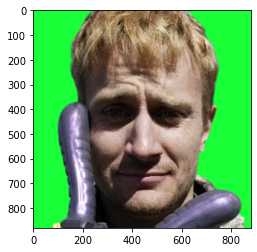

[[ 25 255  55]
 [ 25 255  55]
 [ 25 255  55]
 ...
 [ 25 255  55]
 [ 25 255  55]
 [ 25 254  55]]


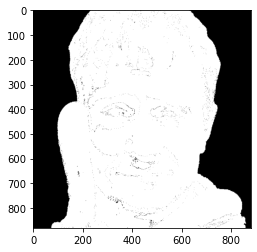

In [15]:
with bf.BlobFile('./gs.png', "rb") as f:
    pil_image = PIL.Image.open(f)
    pil_image.load()
    pil_image = pil_image.convert("RGB")
x = np.array(pil_image, dtype=np.uint8)
plt.imshow(x)
plt.show()
print(x[0])
y = (x[..., [0]] != 25) * (x[..., [1]] != 255) * (x[..., [2]] != 55)
mask = (y * 255).astype(np.uint8)
plt.imshow(mask, cmap='gray')
plt.show()